TODO:
* ~~move GRS stuff to its own class~~
  * ~~double check i'm getting concentrations at the right coordinates~~
  * ~~double check volatile normalization~~
  * ~~double check plotting~~
* ~~data downloader~~
* come up with a crater class

---
# 0. Setup

## Add path to source

In [2]:
## This is OD way to deal with paths

def getPath(*args):
    """Join all arguments into a single path. Use 'current' as a stand in for path to current file."""
    import os
    args = [os.getcwd() if arg == 'current' else arg for arg in args]
    return os.path.abspath(os.path.join(*args))

    
def path_addSrc(fullpath_src = None, relpath_src = None, parent = False, verbose = False):
    """
    Add directory "src/" to path.
        
    PARAMETERS:
        fullpath_src : string
            Path to source from root.
        relpath_src : string
            Path to source from directory of current file.
        parent : boolean
            Use parent folder as source
        verbose : boolean
            Prints source directory path.
    
    RETURN:
        path_src : string
            Path to source from root.
    """
    
    import sys
    import os

    if fullpath_src:
        path_src = getPath(fullpath_src)
    elif relpath_src:
        path_src = getPath('current', relpath_src)
    elif parent:
        path_src = getPath('current', '..')
        
    if verbose: print("Path to source: " + path_src)
    
    sys.path.append(path_src)
    return path_src


path_src = path_addSrc(parent=True, verbose=True)

Path to source: /home/lain/sync/01_Research/Mars_Magnetics/code/05_mag_src_map/src


## Download data

In [9]:
from lib.DataDownloader import DataDownloader as dd

dd.download_folder(path_src=path_src, url="https://drive.google.com/drive/u/0/folders/1D8oWu05X83Xa8dKB1C_SUutBNvbJUt4n", overwrite=False)

Data folder already exists. To overwrite, add `overwrite=True` param.

Data folder contents: 
	README.txt
	craters
	GRS
	crustal_heat_flow
	crustal_thickness


---
# 1. Analysis

In [4]:
import numpy as np
# import scipy.optimize as sy
import matplotlib.pyplot as plt
# from numba import jit
import math


from lib.GRS import GRS as grs

GRS = grs(getPath(path_src, "data/GRS/"))
GRS.loadData()

In [5]:
Lyot = {
    "lon": 29.32,
    "lat": 50.47,
    "formation": 3.4e9,
    "diameter_km": 220.31,
}

In [6]:
# def getCurieDepths_local(lon, lat, t, volatile_adjusted = True):


HPE = {
    "U238": {
        "isotopic_frac": 0.9928,
        "heat_release_const": 9.46e-5, # net energy per unit mass [W/kg]
        "half_life": 4.47e9
    },
    "U235": {
        "isotopic_frac": 0.0071,
        "heat_release_const": 5.69e-4,
        "half_life": 7.04e8
    },
    "Th232": {
        "isotopic_frac": 1.00,
        "heat_release_const": 2.64e-5,
        "half_life": 1.40e10
    },
    "K40": {
        "isotopic_frac": 1.191e-4,
        "heat_release_const": 2.92e-5,
        "half_life": 1.25e9
    }
}


def calc_H(thisGRS, lon, lat, t, volatile_adjusted=True):

    thisHPE = HPE
    
    # get concentrations of each element (these coordinates, current day)
    for element in thisHPE:
        elementname = ''.join([char for char in element if not char.isdigit()]).lower()
        if elementname == 'u':
            concentration = thisGRS.getConcentration(lon, lat, "th", volatile_adjusted) / 3.8
        else:
            concentration = thisGRS.getConcentration(lon, lat, elementname, volatile_adjusted)
    
    
        if concentration == thisGRS.getNanVal():
            return thisGRS.getNanVal()
        thisHPE[element]["concentration"] = concentration
    
    # calculate crustal heat production (these coordinates, `t` years ago)
    H = 0
    for element in thisHPE:
        H += (
            thisHPE[element]["isotopic_frac"] 
            * thisHPE[element]["concentration"] 
            * thisHPE[element]["heat_release_const"] 
            * math.exp((t * math.log(2))/(thisHPE[element]["half_life"]))
        )
    return H
            
    

    
    

In [7]:
def calc_CurieDepths(thisGRS, lon, lat, t, q_b_mW, volatile_adjusted=True):
    H = calc_H(thisGRS, lon, lat, t, volatile_adjusted) # heat production in crust [W kg^-1]    

    if H == thisGRS.getNanVal():
        return (GRS.getNanVal(),)*3

    rho = 2900 # density of crust [kg m^-3]
    # "In Figure 8, we plot the depth of magnetization as a function of crustal thickness. Here we use a crustal thickness model of Wieczorek et al. (2020) which assumes a uniform crustal density of 2,900 kg urn:x-wiley:21699097:media:jgre21714:jgre21714-math-0110 and a minimum crustal thickness of 5 km within the Isidis impact basin."
    
    k_cr = 2.5 # thermal conductivity of crust [W m^-1 K^-1]
    k_m = 4 # thermal conductivity of mantle [W m^-1 K^-1]
    thickness_crust_m = 40e3 # from random map i found online -- eventually automate this!
    q_b = q_b_mW * 10**-3 # basal heat flow, parameter sweep this from 0-50
    
    def calc_T(depth_km):
        depth_m = depth_km*1000
        if depth_m <= thickness_crust_m:
            T = ((rho * H * depth_m)/(k_cr))*(thickness_crust_m - depth_m/2) + (q_b * depth_m)/(k_cr)
        else:
            left = ((rho * H * thickness_crust_m)/(k_cr))*(thickness_crust_m - thickness_crust_m/2) + (q_b * thickness_crust_m)/(k_cr)
            right = ((rho * H * thickness_crust_m**2)/(2*k_m)) + ((q_b * thickness_crust_m)/(k_m))
            T_0 = left-right

            T = T_0 + ((rho * H * thickness_crust_m**2)/(2*k_m)) + ((q_b * depth_m)/(k_m))
        return T
    
    curie_temps = (320,580,670)
    curie_depths = []
    error = 0.01
    
    for curie_temp in curie_temps:
        depth_left = 0
        depth_right = 500
        depth_mid = (depth_right+depth_left)/2

        temp_left = calc_T(depth_left)
        temp_right = calc_T(depth_right)
        temp_mid = calc_T(depth_mid)

        assert temp_left < curie_temp and curie_temp < temp_right, 'erm what the fish'
        
        while abs( temp_mid - curie_temp ) > error:
            if temp_mid < curie_temp:
                depth_left = depth_mid
                temp_left = temp_mid
            else:
                depth_right = depth_mid
                temp_right = temp_mid                
            depth_mid = (depth_right+depth_left)/2
            temp_mid = calc_T(depth_mid)
        
        curie_depths.append(depth_mid)
        
    # for i in range(3):
    #     print(curie_depths[i])
    #     print(calc_T(curie_depths[i]))
    #     print()
        
    return curie_depths
            
    
# thiscrater = Lyot

# # import time
# # start_time = time.time()
# # for i in range(360*180):
# #     x = calc_CurieDepths(GRS, thiscrater['lon'], thiscrater['lat'], thiscrater['formation'], 15, volatile_adjusted=True)
# # s = time.time() - start_time
# # print(s)

# import timeit
# timeit.timeit(lambda: calc_CurieDepths(GRS, thiscrater['lon'], thiscrater['lat'], thiscrater['formation'], 15, volatile_adjusted=True), number = 10000)

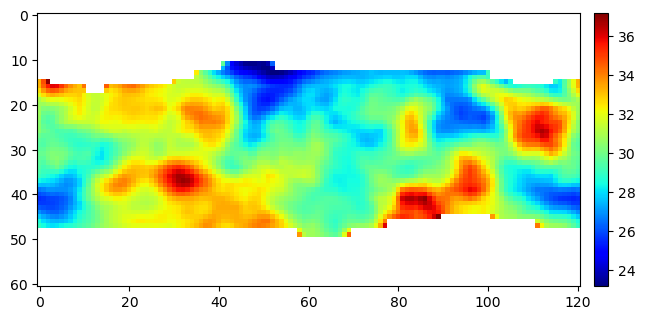

In [8]:
dat = []

for lat in range(-90,91,3):
    newline = []
    for lon in range(-180,181,3):
        x = calc_CurieDepths(GRS, lon, lat, 4e9, 30, volatile_adjusted=True)
        newline.append(x[1])
    dat.append(newline)

# plt.imshow(test[::-1], cmap="jet")
# plt.colorbar()
dat = np.asarray(dat)
dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

fig = plt.figure(figsize=(7,5))
ax = plt.axes()
im = ax.imshow(dat[::-1], cmap="jet")

cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)

In [8]:
fn = getPath(path_src, 'data', 'crustal_thickness', 'Mars-thick-DWThot-30-2900-2900_grid0.1.npy')
dat = np.load(fn)

In [1]:
plt.imshow(dat)

NameError: name 'plt' is not defined